#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [12]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        z_mean, z_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
        return z_mean+tf.exp(0.5*z_var)*epsilon


##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

Motivation : I considered the size of the two dense layer equal to 128 and activation function 'tanh' I set these parameters because in the previous homework I obtained the best outcomes. I have tried again to implement 'relu' or increasing the size of the layers, but the result was worst. The three dense that I take in consideration are : x, x_2 and (z_mena, z_var), I take to simulate the scheme proposed by the professor.
I did not apply an activation function for the z_mean and z_var case because the final plot becomes blurred.

In [94]:
latent_dim = 2
size = 180

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(size, activation='tanh')(encoder_inputs)
x_2 = tf.keras.layers.Dense(size, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x_2)
z_var =  tf.keras.layers.Dense(latent_dim)(x_2)

z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_112 (Dense)               (None, 180)          141300      input_34[0][0]                   
__________________________________________________________________________________________________
dense_113 (Dense)               (None, 180)          32580       dense_112[0][0]                  
__________________________________________________________________________________________________
dense_114 (Dense)               (None, 2)            362         dense_113[0][0]                  
____________________________________________________________________________________________

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

Motivation : For the reason that I explained before (6.2) I consider the same values in which I got the better results during the previous homework.  Sigmoid forces the output to the range between 0 - 1, and it is used because we want to interpret the output as pixel intensity of a gray scale image.

In [95]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(size, activation='tanh')(latent_inputs)
x_2 = tf.keras.layers.Dense(size, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation="sigmoid")(x_2)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_116 (Dense)            (None, 180)               540       
_________________________________________________________________
dense_117 (Dense)            (None, 180)               32580     
_________________________________________________________________
dense_118 (Dense)            (None, 784)               141904    
Total params: 175,024
Trainable params: 175,024
Non-trainable params: 0
_________________________________________________________________


##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [96]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction)))
            temp = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(temp, axis=1))


            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [97]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 5s 11ms/step - loss: 36.1287 - reconstruction_loss: 34.7883 - kl_loss: 1.3404
Epoch 2/30
391/391 [==============================] - 4s 11ms/step - loss: 31.8203 - reconstruction_loss: 30.5446 - kl_loss: 1.2756
Epoch 3/30
391/391 [==============================] - 4s 11ms/step - loss: 30.5832 - reconstruction_loss: 28.5478 - kl_loss: 2.0354
Epoch 4/30
391/391 [==============================] - 4s 11ms/step - loss: 29.9384 - reconstruction_loss: 27.5528 - kl_loss: 2.3856
Epoch 5/30
391/391 [==============================] - 4s 11ms/step - loss: 29.5993 - reconstruction_loss: 26.9841 - kl_loss: 2.6152
Epoch 6/30
391/391 [==============================] - 4s 11ms/step - loss: 29.2979 - reconstruction_loss: 26.4916 - kl_loss: 2.8063
Epoch 7/30
391/391 [==============================] - 4s 11ms/step - loss: 29.0661 - reconstruction_loss: 26.1066 - kl_loss: 2.9595
Epoch 8/30
391/391 [==============================] - 4s 11ms/step - loss: 2

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

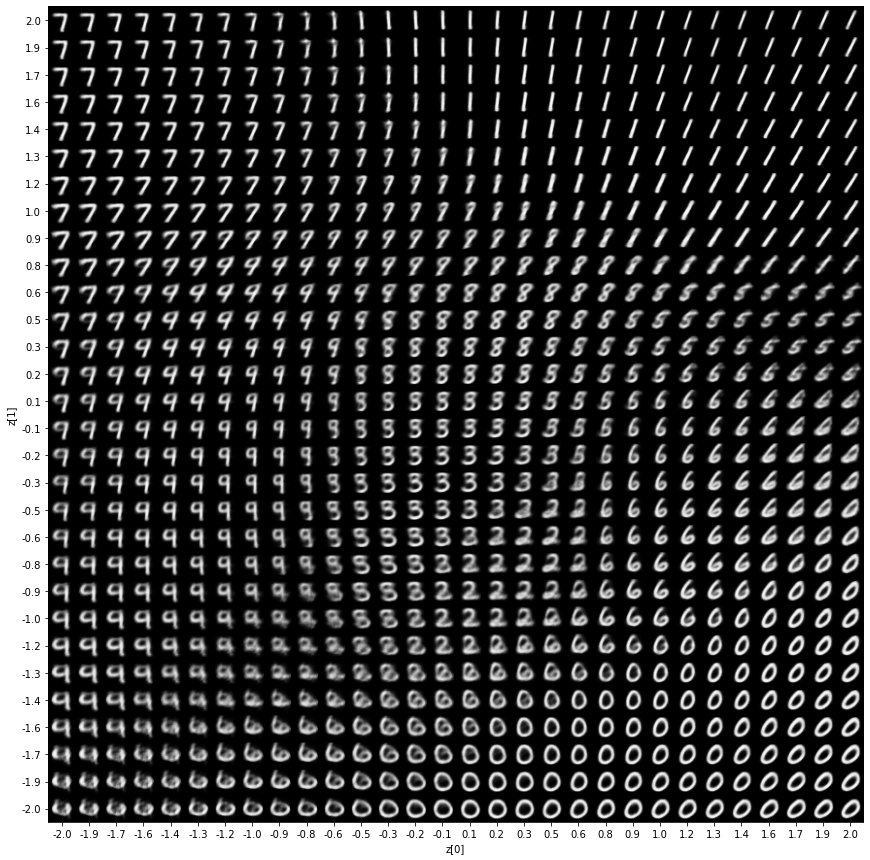

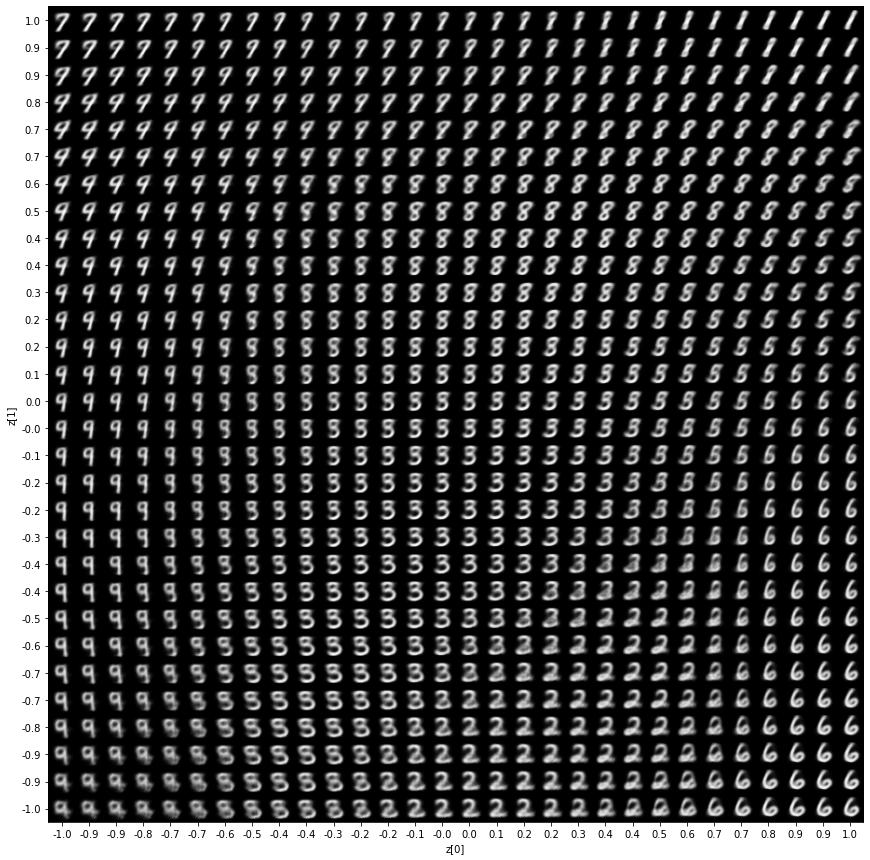

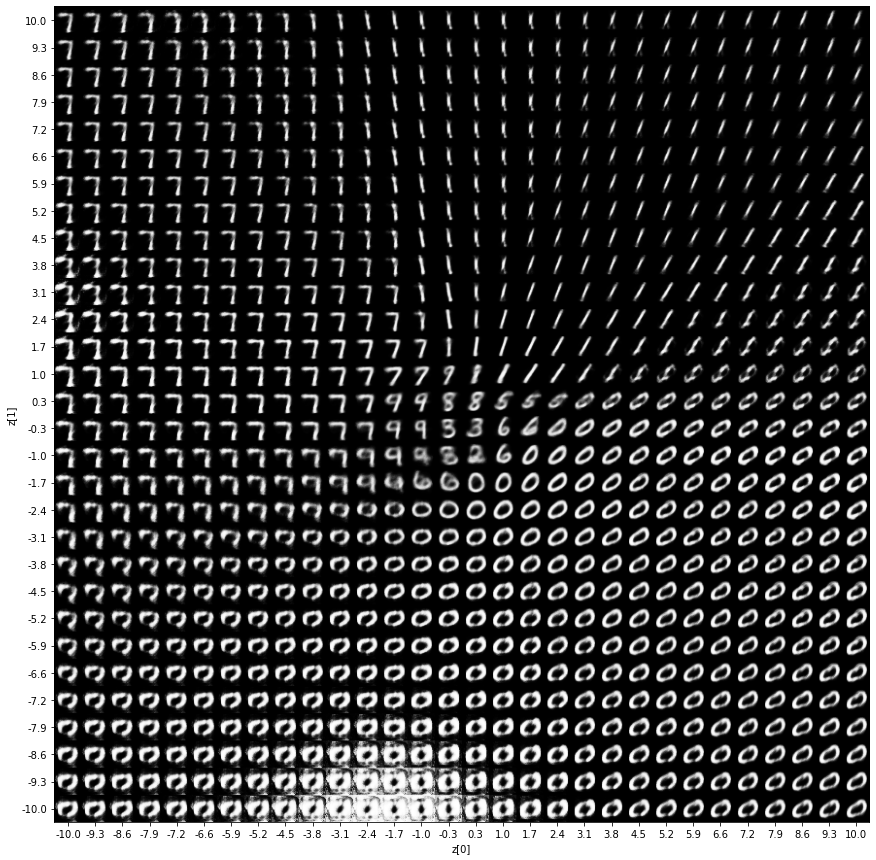

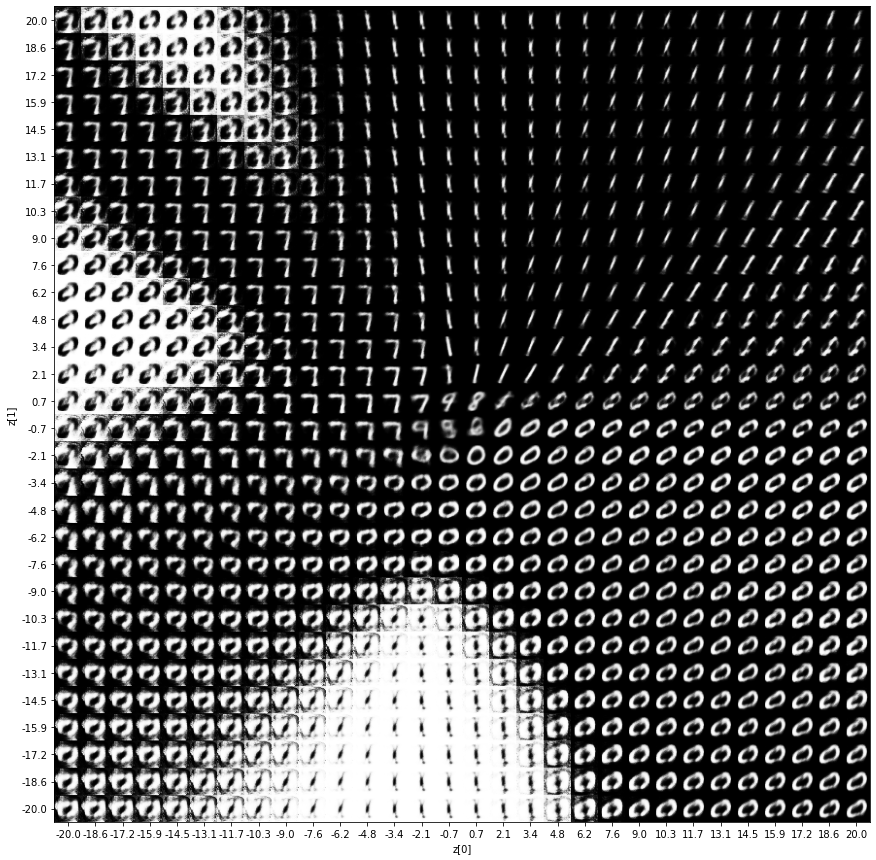

In [98]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30)
plot_latent(encoder, decoder, 1.0, 30) 
plot_latent(encoder, decoder, 10.0, 30) 
plot_latent(encoder, decoder, 20.0, 30) 
#[TO COMPLETE] explore with different "scale"

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

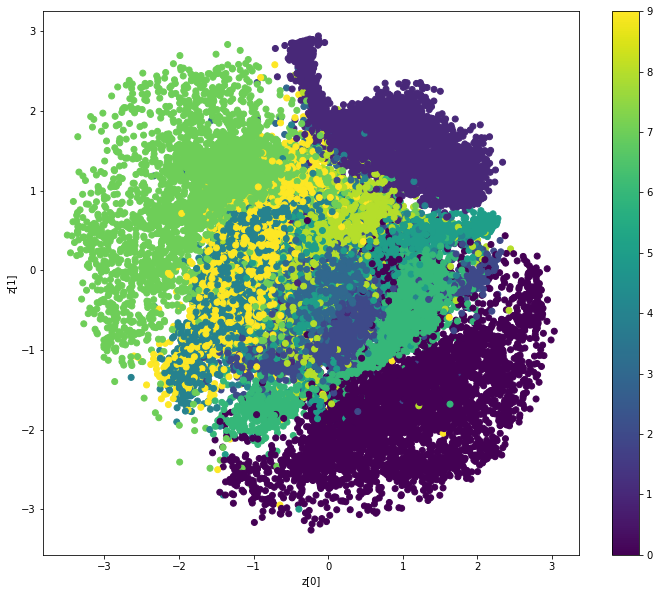

In [99]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

Discussion :
- Digit plot
  - Increasing the interval of the entries of $\hat{z}$ (Scale) the digits result less detectable than the case equal to 2, I reported the plots using 1,2, 10 and 20 scale value.

- Latent space
  - Around the point [0,0] the latent space results continuous and complete. 
  - Around [-1.5,−1] it could be seen some holes, as well as near the borders.

- It's important to notice that the behavior in latent space is also present in the digit representation.

- Hyper-parameters
 - I have initially added an activation functions to z_mean and z_var, but the results were blurred.
 - Increasing the size of the layers there is not a significant improvement and the latent space results more sparse
 - Decreasing the size of the layers the number of parameters decrease and the digits are not detectable and assume a vertical distribution.





